#### Part 29: Advanced GroupBy Operations

In this notebook, we'll explore advanced GroupBy operations in pandas, including:
- Working with MultiIndex
- Grouping by index levels
- Handling categorical data in groupby
- Working with decimal and object columns

##### Setup
First, let's import the necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal

# Set the plotting style
plt.style.use('ggplot')

# Make plots appear in the notebook
%matplotlib inline

##### 1. GroupBy Tab Completion

Let's first create a DataFrame with some demographic data:

In [2]:
# Create a DataFrame with a DatetimeIndex
df = pd.DataFrame({
    'height': np.random.normal(loc=60, scale=10, size=10),
    'weight': np.random.normal(loc=160, scale=15, size=10),
    'gender': np.random.choice(['male', 'female'], size=10)
}, index=pd.date_range('1/1/2000', periods=10))
df

,height,weight,gender
2000-01-01,49.013380,164.117169,female
2000-01-02,59.471915,155.329590,female
2000-01-03,59.227593,159.937697,female
2000-01-04,76.186835,168.880210,female
2000-01-05,71.611262,186.985327,female
2000-01-06,68.761498,177.121775,male
2000-01-07,50.756503,155.905073,male
2000-01-08,50.621670,150.891945,female
2000-01-09,44.795739,167.627149,male
2000-01-10,29.369975,164.229599,male


In [3]:
# Create a GroupBy object
gb = df.groupby('gender')
gb

The GroupBy object has many methods and attributes available. In an interactive session, you can use tab completion to see them all. Here we'll demonstrate some of the most common ones:

In [4]:
# Get the mean of each group
gb.mean()

,height,weight
gender,,
female,61.022109,164.356990
male,48.420929,166.220899


In [5]:
# Get the size of each group
gb.size()

gender
female    6
male      4
dtype: int64

In [6]:
# Get a specific group
gb.get_group('female')

,height,weight,gender
2000-01-01,49.013380,164.117169,female
2000-01-02,59.471915,155.329590,female
2000-01-03,59.227593,159.937697,female
2000-01-04,76.186835,168.880210,female
2000-01-05,71.611262,186.985327,female
2000-01-08,50.621670,150.891945,female


##### 2. GroupBy with MultiIndex

With hierarchically-indexed data, it's quite natural to group by one of the levels of the hierarchy. Let's create a Series with a two-level MultiIndex:

In [7]:
# Create a Series with a two-level MultiIndex
arrays = [['bar', 'bar', 'baz', 'baz', 'foo', 'foo', 'qux', 'qux'],
          ['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two']]
index = pd.MultiIndex.from_arrays(arrays, names=['first', 'second'])
s = pd.Series(np.random.randn(8), index=index)
s

first  second
bar    one      -0.439791
       two      -0.735314
baz    one       0.955987
       two       0.580904
foo    one      -0.625217
       two       0.446540
qux    one      -2.544313
       two       0.844564
dtype: float64

### 2.1 Grouping by Level

We can group by one of the levels in the MultiIndex:

In [8]:
# Group by the first level (level=0)
grouped = s.groupby(level=0)
grouped.sum()

first
bar   -1.175105
baz    1.536890
foo   -0.178677
qux   -1.699750
dtype: float64

In [9]:
# If the MultiIndex has names specified, these can be passed instead of the level number
s.groupby(level='second').sum()

second
one   -2.653334
two    1.136693
dtype: float64

In [11]:
# The aggregation functions such as sum will take the level parameter directly
s.groupby(level='second').sum()

second
one   -2.653334
two    1.136693
dtype: float64

### 2.2 Grouping with Multiple Levels

Grouping with multiple levels is also supported:

In [12]:
# Create a Series with a three-level MultiIndex
arrays = [
    ['bar', 'bar', 'baz', 'baz', 'foo', 'foo', 'qux', 'qux'],
    ['doo', 'doo', 'bee', 'bee', 'bop', 'bop', 'bop', 'bop'],
    ['one', 'two', 'one', 'two', 'one', 'two', 'one', 'two']
]
index = pd.MultiIndex.from_arrays(arrays, names=['first', 'second', 'third'])
s = pd.Series(np.random.randn(8), index=index)
s

first  second  third
bar    doo     one     -0.428586
               two     -0.149202
baz    bee     one      1.403777
               two     -1.158369
foo    bop     one      0.274409
               two      1.639833
qux    bop     one      0.920551
               two     -1.456005
dtype: float64

In [13]:
# Group by multiple levels
s.groupby(level=['first', 'second']).sum()

first  second
bar    doo      -0.577789
baz    bee       0.245408
foo    bop       1.914242
qux    bop      -0.535454
dtype: float64

In [14]:
# Index level names may be supplied as keys
s.groupby(['first', 'second']).sum()

first  second
bar    doo      -0.577789
baz    bee       0.245408
foo    bop       1.914242
qux    bop      -0.535454
dtype: float64

##### 3. Working with Decimal and Object Columns

Any object column, even if it contains numerical values such as Decimal objects, is considered as a "nuisance" column. They are excluded from aggregate functions automatically in groupby.

In [15]:
# Create a DataFrame with a Decimal column
df_dec = pd.DataFrame({
    'id': [1, 2, 1, 2],
    'int_column': [1, 2, 3, 4],
    'dec_column': [Decimal('0.50'), Decimal('0.15'),
                   Decimal('0.25'), Decimal('0.40')]
})
df_dec

,id,int_column,dec_column
0,1,1,0.50
1,2,2,0.15
2,1,3,0.25
3,2,4,0.40


In [16]:
# Decimal columns can be sum'd explicitly by themselves
df_dec.groupby(['id'])[['dec_column']].sum()

,dec_column
id,
1,0.75
2,0.55


In [17]:
# But cannot be combined with standard data types or they will be excluded
df_dec.groupby(['id'])[['int_column', 'dec_column']].sum()

,int_column,dec_column
id,,
1,4,0.75
2,6,0.55


In [18]:
# Use .agg function to aggregate over standard and "nuisance" data types at the same time
df_dec.groupby(['id']).agg({'int_column': 'sum', 'dec_column': 'sum'})

,int_column,dec_column
id,,
1,4,0.75
2,6,0.55


##### 4. Handling of Categorical Values in GroupBy

When using a Categorical grouper, the `observed` keyword controls whether to return a cartesian product of all possible groupers values (`observed=False`) or only those that are observed groupers (`observed=True`).

In [19]:
# Create a Series with a Categorical index
s = pd.Series([1, 1, 1])
cat = pd.Categorical(['a', 'a', 'a'], categories=['a', 'b'])
s

0    1
1    1
2    1
dtype: int64

In [20]:
# Show all values (observed=False)
s.groupby(cat, observed=False).count()

a    3
b    0
dtype: int64

In [21]:
# Show only the observed values (observed=True)
s.groupby(cat, observed=True).count()

a    3
dtype: int64

In [22]:
# The returned dtype of the grouped will always include all of the categories that were grouped
result = s.groupby(cat, observed=False).count()
result.index.dtype

CategoricalDtype(categories=['a', 'b'], ordered=False, categories_dtype=object)

##### 5. Grouping with Ordered Factors

Categorical variables represented as instances of pandas's Categorical class can be used as group keys. If so, the order of the levels will be preserved:

In [23]:
# Create a Series of random data
data = pd.Series(np.random.randn(100))

# Create quartiles as an ordered categorical
factor = pd.qcut(data, [0, .25, .5, .75, 1.])

# Group by the factor and compute the mean
data.groupby(factor).mean()

/var/folders/7y/fzwln1_93mn3js3wyk61_6xm0000gn/T/ipykernel_76487/159001472.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(factor).mean()


(-2.089, -0.846]   -1.384833
(-0.846, 0.127]    -0.322159
(0.127, 0.676]      0.427436
(0.676, 2.705]      1.334636
dtype: float64

##### 6. NA and NaT Group Handling

If there are any NaN or NaT values in the grouping key, these will be automatically excluded. In other words, there will never be an "NA group" or "NaT group".

In [24]:
# Create a Series with NaN values in the index
s = pd.Series([1, 2, 3, 4], index=[1, 2, np.nan, np.nan])
s

1.0    1
2.0    2
NaN    3
NaN    4
dtype: int64

In [25]:
# Group by index - NaN values are excluded
s.groupby(level=0).sum()

1.0    1
2.0    2
dtype: int64

##### 7. Practical Examples of GroupBy Operations

Let's look at some practical examples of GroupBy operations:

In [26]:
# Create a DataFrame with sales data
sales = pd.DataFrame({
    'date': pd.date_range('2023-01-01', periods=20),
    'product': np.random.choice(['A', 'B', 'C'], size=20),
    'region': np.random.choice(['North', 'South', 'East', 'West'], size=20),
    'sales': np.random.randint(100, 1000, size=20),
    'units': np.random.randint(1, 10, size=20)
})
sales.head()

,date,product,region,sales,units
0,2023-01-01,A,West,896,4
1,2023-01-02,A,East,214,6
2,2023-01-03,B,East,760,9
3,2023-01-04,A,South,152,5
4,2023-01-05,A,North,839,1


In [27]:
# Group by product and calculate total sales and average units
product_summary = sales.groupby('product').agg({
    'sales': 'sum',
    'units': 'mean'
})
product_summary

,sales,units
product,,
A,6317,5.083333
B,3738,5.200000
C,1342,6.000000


In [28]:
# Group by region and product
region_product = sales.groupby(['region', 'product']).agg({
    'sales': ['sum', 'mean'],
    'units': ['sum', 'mean']
})
region_product

sales        units          
                 sum   mean   sum      mean
region product                             
East   A        2154  718.0    13  4.333333
       B         760  760.0     9  9.000000
       C         532  532.0     5  5.000000
North  A        3115  445.0    39  5.571429
       B         986  986.0     8  8.000000
       C         810  405.0    13  6.500000
South  A         152  152.0     5  5.000000
       B        1554  777.0     6  3.000000
West   A         896  896.0     4  4.000000
       B         438  438.0     3  3.000000

In [29]:
# Group by date (month) and calculate monthly sales
sales['month'] = sales['date'].dt.month
monthly_sales = sales.groupby('month')['sales'].sum()
monthly_sales

month
1    11397
Name: sales, dtype: int64

(array([0]), [Text(0, 0, '1')])

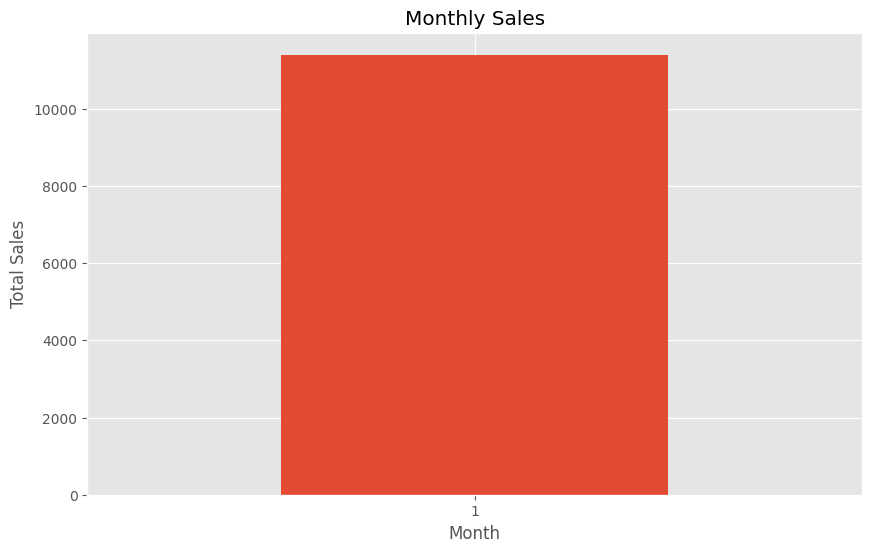

In [30]:
# Visualize monthly sales
monthly_sales.plot(kind='bar', figsize=(10, 6), title='Monthly Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=0)

##### Summary

In this notebook, we've explored advanced GroupBy operations in pandas, including:

1. GroupBy tab completion and common methods
2. Working with MultiIndex in GroupBy operations
   - Grouping by level
   - Grouping with multiple levels
3. Working with decimal and object columns in GroupBy
4. Handling of categorical values in GroupBy with the `observed` parameter
5. Grouping with ordered factors
6. NA and NaT group handling
7. Practical examples of GroupBy operations

These advanced GroupBy techniques provide powerful tools for data analysis and aggregation in pandas.